In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.tree import DecisionTreeClassifier , plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
print(os.listdir('.'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


In [0]:
os.listdir('gdrive/My Drive/CITS5504_Proj2')

['out_test.csv',
 'out.csv',
 'CITS5504_P2PLAN.gdoc',
 'Untitled0.ipynb',
 'Code_testingMatt.ipynb',
 'out.gsheet',
 'CITS5504 Write-up.gdoc',
 'CodeTestingMatt1.ipynb']

In [0]:
pathname = 'gdrive/My Drive/CITS5504_Proj2'

# 1.0 Read in Data

In [0]:
train_data = pd.read_csv(pathname + '/' + "out.csv")
test_data = pd.read_csv(pathname + '/' + "out_test.csv")

In [0]:
train_data["hoursgroup"]=train_data["hoursgroup"].fillna("0-20")
test_data["hoursgroup"]=test_data["hoursgroup"].fillna("0-20")

In [0]:
num_attribs = ["age", "hours.per.week"]
cat_attribs = ["workclass","agegroup","education","marital.status","occupation","relationship","race","sex","hoursgroup","native.country","marriedprevnever","married_once_or_never","Highest_level_ed","University_Graduate","Racial_group","income"]
new_training = pd.DataFrame()
new_testing = pd.DataFrame()
training_cat = train_data[cat_attribs]
testing_cat = test_data[cat_attribs]
for i in range(len(cat_attribs)):
  le = LabelEncoder()
  new_training[cat_attribs[i]] = le.fit_transform(training_cat[cat_attribs[i]])

for i in range(len(cat_attribs)):
  le = LabelEncoder()
  new_testing[cat_attribs[i]] = le.fit_transform(testing_cat[cat_attribs[i]])

new_training["age"] = train_data["age"]
new_training["hours.per.week"] = train_data["hours.per.week"]
new_testing["age"] = test_data["age"]
new_testing["hours.per.week"] = test_data["hours.per.week"]

## 1.1 Create Training and Test Sets

In [0]:
x_cols_original = ["workclass","age","hours.per.week","agegroup","education","marital.status","occupation","relationship","sex","hoursgroup","marriedprevnever","married_once_or_never","Highest_level_ed","University_Graduate",
              "Racial_group", "native.country"]
y_cols_original = ["income"]
x_train_original = new_training[x_cols_original]
y_train_original = new_training[y_cols_original]
x_test_original = new_testing[x_cols_original]
y_test_original = new_testing[y_cols_original]

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_original)
x_test_scaled = scaler.transform(x_test_original)

In [0]:
y_train_original['income'].value_counts()[0]

24720

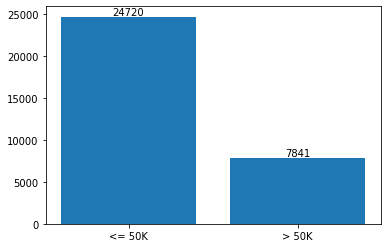

In [0]:
x_labels = ('<= 50K','> 50K')
y_labels = (y_train_original['income'].value_counts()[0],y_train_original['income'].value_counts()[1])
plt.bar(x_labels, y_labels)
for x, y in zip(x_labels, y_labels):
  label = y
  plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,2), ha='center')
plt.show()

#2.0 Classification

In [0]:
def metric_scores_kfold(classifier, x, y, folds,value_col_name):
  crv = cross_validate(classifier, x, y, cv=folds, scoring = ('recall','precision', 'accuracy','f1'))
  accuracy_mean = crv['test_accuracy'].mean()
  precision_mean = crv['test_precision'].mean()
  recall_mean = crv['test_recall'].mean()
  f1_mean = crv['test_f1'].mean()

  summary_arr = np.array([accuracy_mean,precision_mean,recall_mean,f1_mean])
  summary_df = pd.DataFrame({'metric': ['Accuracy','Precision','Recall','F1'], value_col_name: summary_arr})

  return summary_df


## 2.1 Decision Tree with Manually Selected Attributes

### 2.1.1 Create Dataset with manually selected attributes

In [0]:
# set attributes we think will be strong classifiers of income
x_cols_md1 = ["Highest_level_ed", "occupation", "agegroup","workclass","hoursgroup"]
x_tr_md1 = x_train_original[x_cols_md1]
x_te_md1 = x_test_original[x_cols_md1]


### 2.1.2 Fit Decision Tree

In [0]:
dt_clf_1 = DecisionTreeClassifier(criterion='entropy',max_depth = 5,random_state=42)
dt_clf_1.fit(x_tr_md1,y_train_original)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 2.1.3 10-Fold Cross Validate

In [0]:
md1_metrics = metric_scores_kfold(dt_clf_1, x_tr_md1, y_train_original, 10, 'DT Manual Selection')
md1_metrics

,metric,DT Manual Selection
0,Accuracy,0.778938
1,Precision,0.587341
2,Recall,0.284020
3,F1,0.379304


### 2.1.4 Visualise the Decision Tree

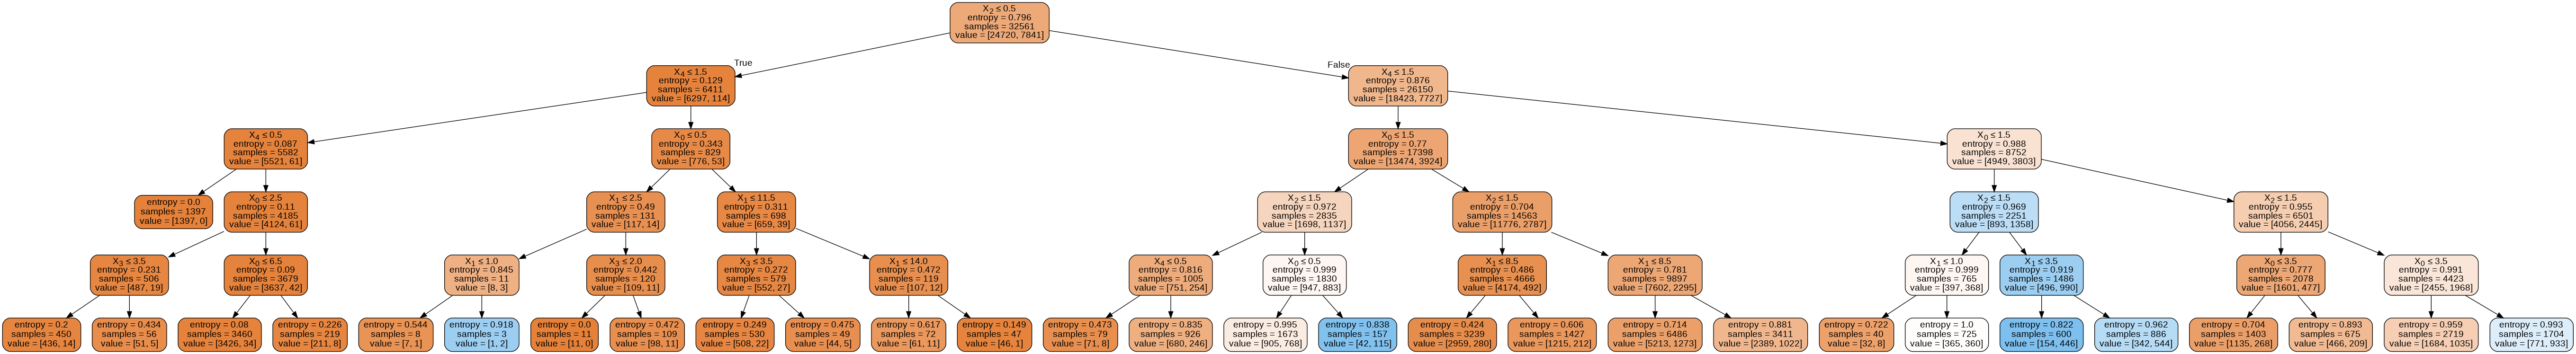

In [0]:
dot_data = StringIO()
export_graphviz(dt_clf_1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
print(x_train_original['Highest_level_ed'].value_counts(),train_data['Highest_level_ed'].value_counts())

3    17792
0     5355
5     3701
7     3025
4     1723
1      413
2      333
6      219
Name: Highest_level_ed, dtype: int64 High School          17792
Bachelors             5355
Middle School         3701
Trade School          3025
Masters               1723
Doctorate              413
Elementary School      333
Preschool              219
Name: Highest_level_ed, dtype: int64


In [0]:
r_1 = export_text(dt_clf_1, feature_names=x_cols_md1)
print(r_1)

|--- agegroup <= 0.50
|   |--- hoursgroup <= 1.50
|   |   |--- hoursgroup <= 0.50
|   |   |   |--- class: 0
|   |   |--- hoursgroup >  0.50
|   |   |   |--- Highest_level_ed <= 2.50
|   |   |   |   |--- workclass <= 3.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- workclass >  3.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Highest_level_ed >  2.50
|   |   |   |   |--- Highest_level_ed <= 6.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Highest_level_ed >  6.50
|   |   |   |   |   |--- class: 0
|   |--- hoursgroup >  1.50
|   |   |--- Highest_level_ed <= 0.50
|   |   |   |--- occupation <= 2.50
|   |   |   |   |--- occupation <= 1.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- occupation >  1.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- occupation >  2.50
|   |   |   |   |--- workclass <= 2.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- workclass >  2.00
|   |   |   |   |   |--- class: 0
|   |   |--- Highest_level_ed >  0.50


## 2.2 Decision Tree with Attributes Selected by Information Gain

### 2.2.1 Create Dataset

In [0]:
x_cols_md2 = ["relationship", "marital.status", "marriedprevnever","age","education"]
x_tr_md2 = x_train_original[x_cols_md2]
x_te_md2 = x_test_original[x_cols_md2]

### 2.2.2 Fit Decision Tree

In [0]:
dt_clf_2 = DecisionTreeClassifier(criterion='entropy',max_depth = 5,random_state=42)
dt_clf_2.fit(x_tr_md2,y_train_original)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 2.2.3 10-Fold Cross Validation

In [0]:
md2_metrics = metric_scores_kfold(dt_clf_2, x_tr_md2, y_train_original, 10, 'DT Information Gain')

In [0]:
md2_metrics

,metric,DT Information Gain
0,Accuracy,0.812936
1,Precision,0.623911
2,Recall,0.562170
3,F1,0.590873


### 2.3.4 Visualise the Decision Tree

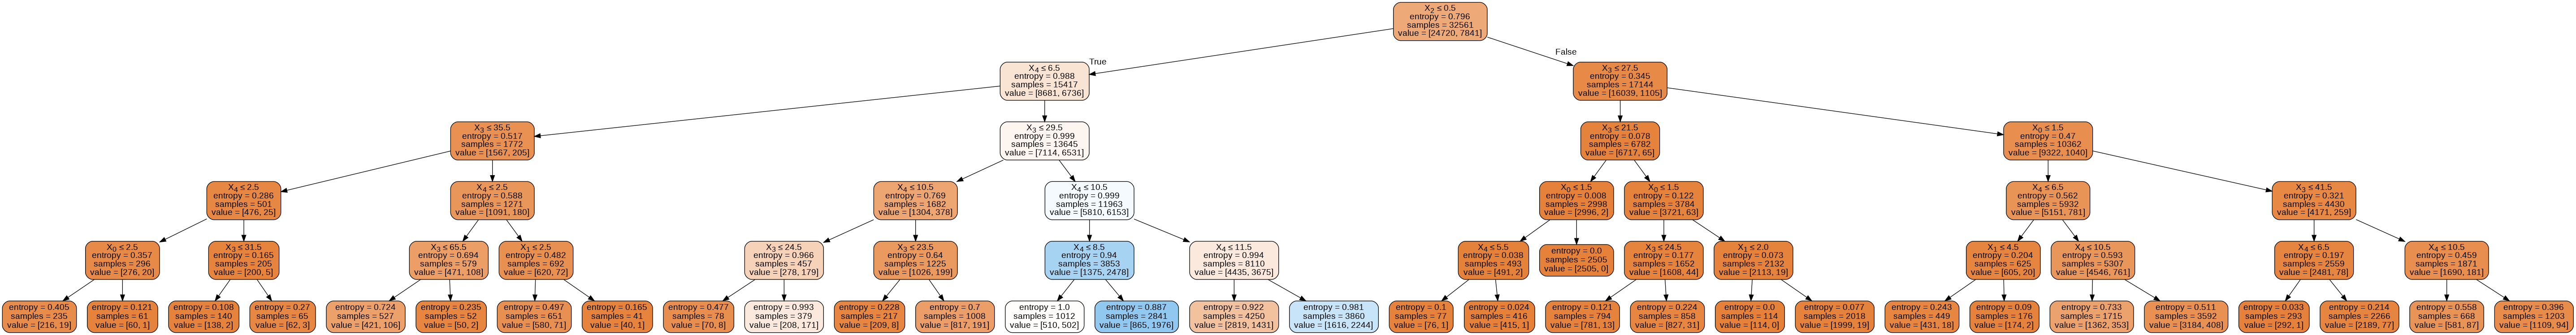

In [0]:
dot_data = StringIO()
export_graphviz(dt_clf_2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
r_2 = export_text(dt_clf_2, feature_names=x_cols_md2)
print(r_2)

|--- marriedprevnever <= 0.50
|   |--- education <= 6.50
|   |   |--- age <= 35.50
|   |   |   |--- education <= 2.50
|   |   |   |   |--- relationship <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- relationship >  2.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- education >  2.50
|   |   |   |   |--- age <= 31.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  31.50
|   |   |   |   |   |--- class: 0
|   |   |--- age >  35.50
|   |   |   |--- education <= 2.50
|   |   |   |   |--- age <= 65.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  65.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- education >  2.50
|   |   |   |   |--- marital.status <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- marital.status >  2.50
|   |   |   |   |   |--- class: 0
|   |--- education >  6.50
|   |   |--- age <= 29.50
|   |   |   |--- education <= 10.50
|   |   |   |   |--- age <= 24.50
|   |   |   |   |   |--- class: 0
|   |   |   | 

In [0]:
print(x_train_original['education'].value_counts(),train_data['education'].value_counts())

11    10501
15     7291
9      5355
12     1723
8      1382
1      1175
7      1067
0       933
5       646
14      576
6       514
2       433
10      413
4       333
3       168
13       51
Name: education, dtype: int64 HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64


In [0]:
evaluation_dfc1 = pd.DataFrame()
evaluation_dfc1 = pd.concat([md1_metrics,md2_metrics.iloc[:,1]],axis=1)
evaluation_dfc1

,metric,DT Manual Selection,DT Information Gain
0,Accuracy,0.778938,0.812936
1,Precision,0.587341,0.623911
2,Recall,0.284020,0.562170
3,F1,0.379304,0.590873


# 3.0 Reduce the Data

## 3.1 Numerosity Reduction by Stratified Sampling

### 3.1.1 Reduce and Stratify the Data

In [0]:
new_training.head()

,workclass,agegroup,education,marital.status,occupation,relationship,race,sex,hoursgroup,native.country,marriedprevnever,married_once_or_never,Highest_level_ed,University_Graduate,Racial_group,income,age,hours.per.week
0,6,2,9,4,0,1,4,1,1,38,1,1,0,1,1,0,39,40
1,5,3,9,2,3,0,4,1,0,38,0,0,0,1,1,0,50,13
2,3,2,11,0,5,1,4,1,1,38,2,0,3,0,1,0,38,40
3,3,3,1,2,5,0,2,1,1,38,0,0,5,0,0,0,53,40
4,3,1,9,2,9,5,2,0,1,4,0,0,0,1,0,0,28,40


In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,test_index in split.split(new_training,new_training["income"]):
  nreduced_useless = new_training.loc[train_index]
  nreduced_data = new_training.loc[test_index]

In [0]:
print("Class Proportions Reduced\n",nreduced_data["income"].value_counts()/len(nreduced_data))
print("Class Proportions Original\n",new_training["income"].value_counts()/len(new_training))
print("Class Count Reduced\n",nreduced_data["income"].value_counts())
print("Class Count Original\n",new_training["income"].value_counts())

Class Proportions Reduced
 0    0.759251
1    0.240749
Name: income, dtype: float64
Class Proportions Original
 0    0.75919
1    0.24081
Name: income, dtype: float64
Class Count Reduced
 0    4945
1    1568
Name: income, dtype: int64
Class Count Original
 0    24720
1     7841
Name: income, dtype: int64


In [0]:
x_tr_md3 = nreduced_data.drop(['income'],axis=1)
y_tr_md3 = nreduced_data['income']

### 3.1.1 Train a New Decision Tree

In [0]:
dt_clf_3 = DecisionTreeClassifier(max_depth=5,criterion='entropy', random_state=42)
dt_clf_3.fit(x_tr_md3,y_tr_md3)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 3.1.2 10-Fold Cross Validation

In [0]:
md3_metrics = metric_scores_kfold(dt_clf_3, x_tr_md3, y_tr_md3, 10, 'DT Stratified')

In [0]:
md3_metrics

,metric,DT Stratified
0,Accuracy,0.821893
1,Precision,0.690213
2,Recall,0.471921
3,F1,0.560261


## 3.2 Dimensionality Reduction by PCA

### 3.2.1 Reduce the Data

In [0]:
pca_md4 = PCA(0.95)
x_pca_md4 = pca_md4.fit_transform(x_train_scaled)

In [0]:
# explained variance
pca_md4.explained_variance_ratio_

array([0.20523856, 0.1263662 , 0.09969754, 0.09339331, 0.07894827,
       0.07183408, 0.06256319, 0.06049269, 0.05431396, 0.04288688,
       0.0371855 , 0.02466322])

### 3.2.2 Train a new Decision Tree

In [0]:
dt_clf_4 = DecisionTreeClassifier(max_depth=5,criterion='entropy', random_state=42)
dt_clf_4.fit(x_pca_md4,y_train_original)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 3.2.3 10 Fold Cross Validate

In [0]:
md4_metrics = metric_scores_kfold(dt_clf_4, x_pca_md4, y_train_original, 10, 'DT PCA')
md4_metrics

,metric,DT PCA
0,Accuracy,0.810694
1,Precision,0.639868
2,Recall,0.504902
3,F1,0.560687


## 3.3 Combine PCA and numerosity reduction

### 3.3.1 Prepare Data

In [0]:
#x_tr_md3
#y_tr_md3
x_tr_md5 = scaler.fit_transform(x_tr_md3)
pca_md5 = PCA(0.95)
x_pca_md5 = pca_md5.fit_transform(x_tr_md5)

In [0]:
pca_md5.explained_variance_ratio_


array([0.19707335, 0.12160535, 0.10891208, 0.09388178, 0.08861702,
       0.07497643, 0.0634977 , 0.05675495, 0.05406607, 0.04014616,
       0.03625123, 0.02296081])

### 3.3.2 Train a Decision Tree

In [0]:
dt_clf_5 = DecisionTreeClassifier(max_depth=5,criterion='entropy', random_state=42)
dt_clf_5.fit(x_pca_md5,y_tr_md3)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 3.3.3 10 Fold Cross Validate

In [0]:
md5_metrics = metric_scores_kfold(dt_clf_5, x_pca_md5, y_tr_md3, 10, 'DT PCA Sampling')
md5_metrics

,metric,DT PCA Sampling
0,Accuracy,0.802703
1,Precision,0.618282
2,Recall,0.494247
3,F1,0.544269


## 3.4 Decision Tree on Original Data

### 3.4.1 Train a new model

In [0]:
dt_clf_6 = DecisionTreeClassifier(criterion='entropy',max_depth = 5,random_state=42)
dt_clf_6.fit(x_train_original,y_train_original)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 3.4.2 10 Fold Cross Validate

In [0]:
md6_metrics = metric_scores_kfold(dt_clf_6, x_train_original,y_train_original, 10, 'DT Full Data')
md6_metrics

,metric,DT Full Data
0,Accuracy,0.819876
1,Precision,0.706814
2,Recall,0.433870
3,F1,0.536185


## 3.5 Evaluate All Decision Trees

In [0]:
evaluation_df1 = pd.DataFrame()
evaluation_df1 = pd.concat([md1_metrics,md2_metrics.iloc[:,1],md3_metrics.iloc[:,1],md4_metrics.iloc[:,1],md5_metrics.iloc[:,1],md6_metrics.iloc[:,1]],axis=1)


In [0]:
evaluation_df1

,metric,DT Manual Selection,DT Information Gain,DT Stratified,DT PCA,DT PCA Sampling,DT Full Data
0,Accuracy,0.778938,0.812936,0.821893,0.810694,0.802703,0.819876
1,Precision,0.587341,0.623911,0.690213,0.639868,0.618282,0.706814
2,Recall,0.284020,0.562170,0.471921,0.504902,0.494247,0.433870
3,F1,0.379304,0.590873,0.560261,0.560687,0.544269,0.536185


# 4.0 Create a better model

In [0]:
labels = np.array(y_train_original['income'])
feature_list = list(x_train_original.columns)
features = np.array(x_train_original)

In [0]:
from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
oversample = SMOTE()
new_x, new_y = oversample.fit_resample(features, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
print(Counter(new_y))

Counter({0: 24720, 1: 24720})


In [0]:
rf_clf_1 = RandomForestClassifier(n_estimators=300, criterion='entropy')
rf_clf_1.fit(new_x, new_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
md7_metrics = metric_scores_kfold(rf_clf_1, new_x, new_y, 5, 'rf_1')
md7_metrics

,metric,rf_1
0,Accuracy,0.867253
1,Precision,0.848046
2,Recall,0.894620
3,F1,0.869326
